<a href="https://colab.research.google.com/github/VictorFu0717/AI/blob/main/transfer_gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

遷移學習:只有用後面的mlp,gap訓練
1.   偷VGG16
2.   接分類器

1.   訓練：cnn固定-->分類器調整

In [ ]:
import zipfile
path = "drive/MyDrive/train.zip "
f = zipfile.ZipFile(path)
f.extractall()
#解壓縮在同一層

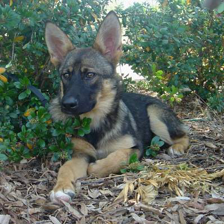

In [ ]:
import glob
from PIL import Image
fs = glob.glob("train/*")
Image.open(fs[666]).resize((224, 224)).convert("RGB")
#調整大小

In [ ]:

import pandas as pd
dog = glob.glob("train/dog.*")
cat = glob.glob("train/cat.*")
datas = pd.DataFrame({
        "path":dog + cat,
        "ans":[0] * len(dog) + [1] * len(cat)
})
datas

,path,ans
0,train/dog.9624.jpg,0
1,train/dog.5069.jpg,0
2,train/dog.8989.jpg,0
3,train/dog.2228.jpg,0
4,train/dog.1737.jpg,0
...,...,...
24995,train/cat.7770.jpg,1
24996,train/cat.11348.jpg,1
24997,train/cat.8289.jpg,1
24998,train/cat.2755.jpg,1


In [ ]:
# 在keras appliation偷模型
# include_top要不要當初的mlp
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
# Trainbale + 1024 (Step2: 最優化)
# Non + 1024 (Step1: 標準標準化)
vgg_layers = vgg.layers
for l in vgg_layers:
    l.trainable = False
clf_layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(vgg_layers + clf_layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(), 
       optimizer="adam",
       metrics=["accuracy"])

In [ ]:
# demo pre: 你的預處理也要抄當初的預處理,這裡不可以除以255,因為原本不是用tensorflow
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fs[5000]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[128.061   , 113.221   , 112.32    ],
        [128.061   , 113.221   , 112.32    ],
        [128.061   , 113.221   , 112.32    ],
        ...,
        [124.061   , 109.221   , 108.32    ],
        [124.061   , 109.221   , 108.32    ],
        [124.061   , 109.221   , 108.32    ]],

       [[128.061   , 113.221   , 112.32    ],
        [128.061   , 113.221   , 112.32    ],
        [128.061   , 113.221   , 112.32    ],
        ...,
        [124.061   , 109.221   , 108.32    ],
        [124.061   , 109.221   , 108.32    ],
        [124.061   , 109.221   , 108.32    ]],

       [[129.061   , 114.221   , 113.32    ],
        [129.061   , 114.221   , 113.32    ],
        [129.061   , 114.221   , 113.32    ],
        ...,
        [124.061   , 109.221   , 108.32    ],
        [124.061   , 109.221   , 108.32    ],
        [124.061   , 109.221   , 108.32    ]],

       ...,

       [[ 43.060997, -31.779   , -84.68    ],
        [ 44.060997, -30.779   , -83.68    ],
        [ 45.060997, -

In [ ]:
x, y = np.array(datas["path"]), np.array(datas["ans"])

In [ ]:
#batch多少張調整一次梯度下降
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    y_batch = y[idx]
    x_batch, x_batch_ori = [], []
    for p in x[idx]:
        img = Image.open(p).resize((224, 224)).convert("RGB")
        img_np = np.array(img) 
        img_np_pre = preprocess_input(img_np)
        x_batch.append(img_np_pre)
        x_batch_ori.append(img_np)
    return (np.array(x_batch), np.array(y_batch), np.array(x_batch_ori))
x_batch, y_batch, x_batch_ori = get_data(x, y)
print(x_batch.shape)
print(y_batch.shape)
print(x_batch_ori.shape)

(20, 224, 224, 3)
(20,)
(20, 224, 224, 3)


In [ ]:
for i in range(20):
    print("-" * 15, i, "-" * 15)
    x_batch, y_batch, x_batch_ori = get_data(x, y)
    result = model.train_on_batch(x_batch, y_batch)
    print("[Train]:", result)
    x_batch, y_batch, x_batch_ori = get_data(x, y)
    result = model.test_on_batch(x_batch, y_batch)
    print("[Validate]:", result)

--------------- 0 ---------------
[Train]: [0.6788280606269836, 0.550000011920929]
[Validate]: [3.4890754222869873, 0.5]
--------------- 1 ---------------
[Train]: [0.6021162271499634, 0.6499999761581421]
[Validate]: [1.2506093978881836, 0.550000011920929]
--------------- 2 ---------------
[Train]: [0.6532959938049316, 0.5]
[Validate]: [1.707021951675415, 0.6000000238418579]
--------------- 3 ---------------
[Train]: [0.6734435558319092, 0.6499999761581421]
[Validate]: [1.71627938747406, 0.550000011920929]
--------------- 4 ---------------
[Train]: [0.5695766806602478, 0.699999988079071]
[Validate]: [0.8085616827011108, 0.75]
--------------- 5 ---------------
[Train]: [0.538803219795227, 0.800000011920929]
[Validate]: [1.3364598751068115, 0.5]
--------------- 6 ---------------
[Train]: [0.5982731580734253, 0.75]
[Validate]: [0.5518463850021362, 0.75]
--------------- 7 ---------------
[Train]: [0.6107234358787537, 0.699999988079071]
[Validate]: [0.2341490536928177, 0.8999999761581421]
-

In [ ]:
model.predict(x_batch)

array([[0.12079348, 0.87920654],
       [0.03245085, 0.9675492 ],
       [0.573426  , 0.42657402],
       [0.6876662 , 0.31233385],
       [0.94859934, 0.05140065],
       [0.87166023, 0.12833975],
       [0.9588768 , 0.04112321],
       [0.08804872, 0.9119513 ],
       [0.93763983, 0.06236013],
       [0.05594007, 0.94405997],
       [0.7246697 , 0.2753303 ],
       [0.10989796, 0.890102  ],
       [0.07162702, 0.9283729 ],
       [0.27261308, 0.72738695],
       [0.81571823, 0.18428174],
       [0.05046565, 0.94953436],
       [0.06886952, 0.9311304 ],
       [0.914834  , 0.08516596],
       [0.45731696, 0.54268306],
       [0.08808935, 0.91191065]], dtype=float32)

In [ ]:
x_batch, y_batch, x_batch_ori = get_data(x, y, 2000)
model.evaluate(x_batch, y_batch)

63/63 [==============================] - 19s 200ms/step - loss: 0.3862 - accuracy: 0.8365


[0.38624730706214905, 0.8364999890327454]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


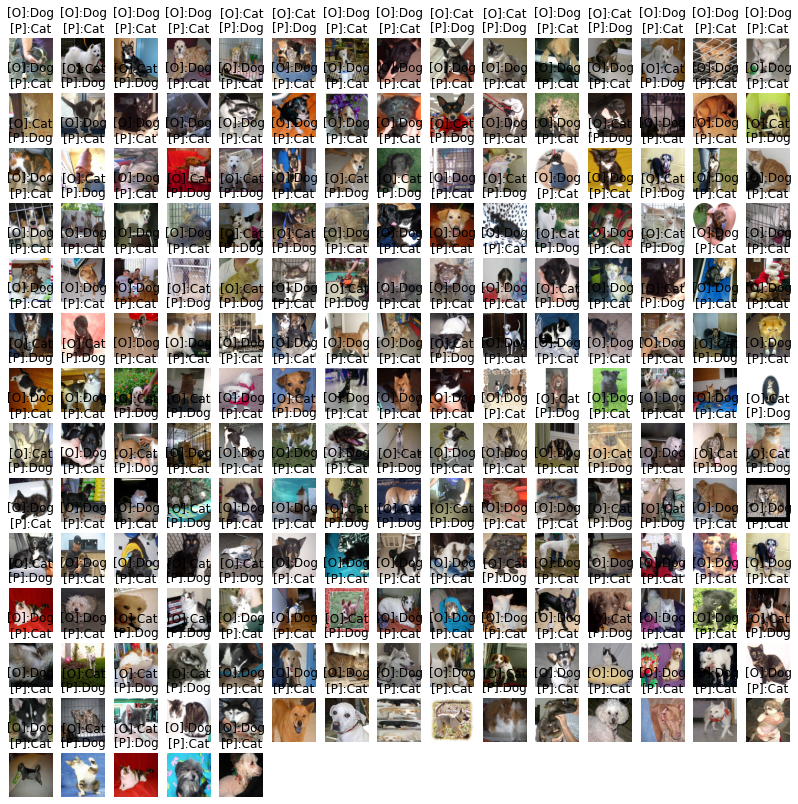

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pre = model.predict_classes(x_batch)
trans = ["Dog", "Cat"]
idx = np.nonzero(pre != y_batch)[0][:200]
false_img = x_batch_ori[idx]
false_pre = pre[idx]
false_label = y_batch[idx]
plt.figure(figsize=(14, 14))
width = 15
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])

In [ ]:
# Pillow
import requests
from PIL import Image
# RGB, RGBA, L(gray)
url = input("url:")
headers = {
  "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36"  
}
response = requests.get(url, headers=headers, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_r = preprocess_input(img_np.reshape(1, 224, 224, 3))
proba = model.predict(img_np_r)[0]
for i, p in enumerate(proba):
    print(trans[i], "的機率:", p)
ans = model.predict_classes(img_np_r)[0]
print("答案:", trans[ans])
plt.imshow(img_np)